<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  FamilySize   891 non-null    int64  
 13  Title        891 non-null    object 
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB
[0]	validation_0-logloss:0.66191
[1]	validation_0-logloss:0.65716
[2]	validation_0-logloss:0.65278
[3]	validation_0-logloss:0.64854
[4]	validation_0-logloss:0.6

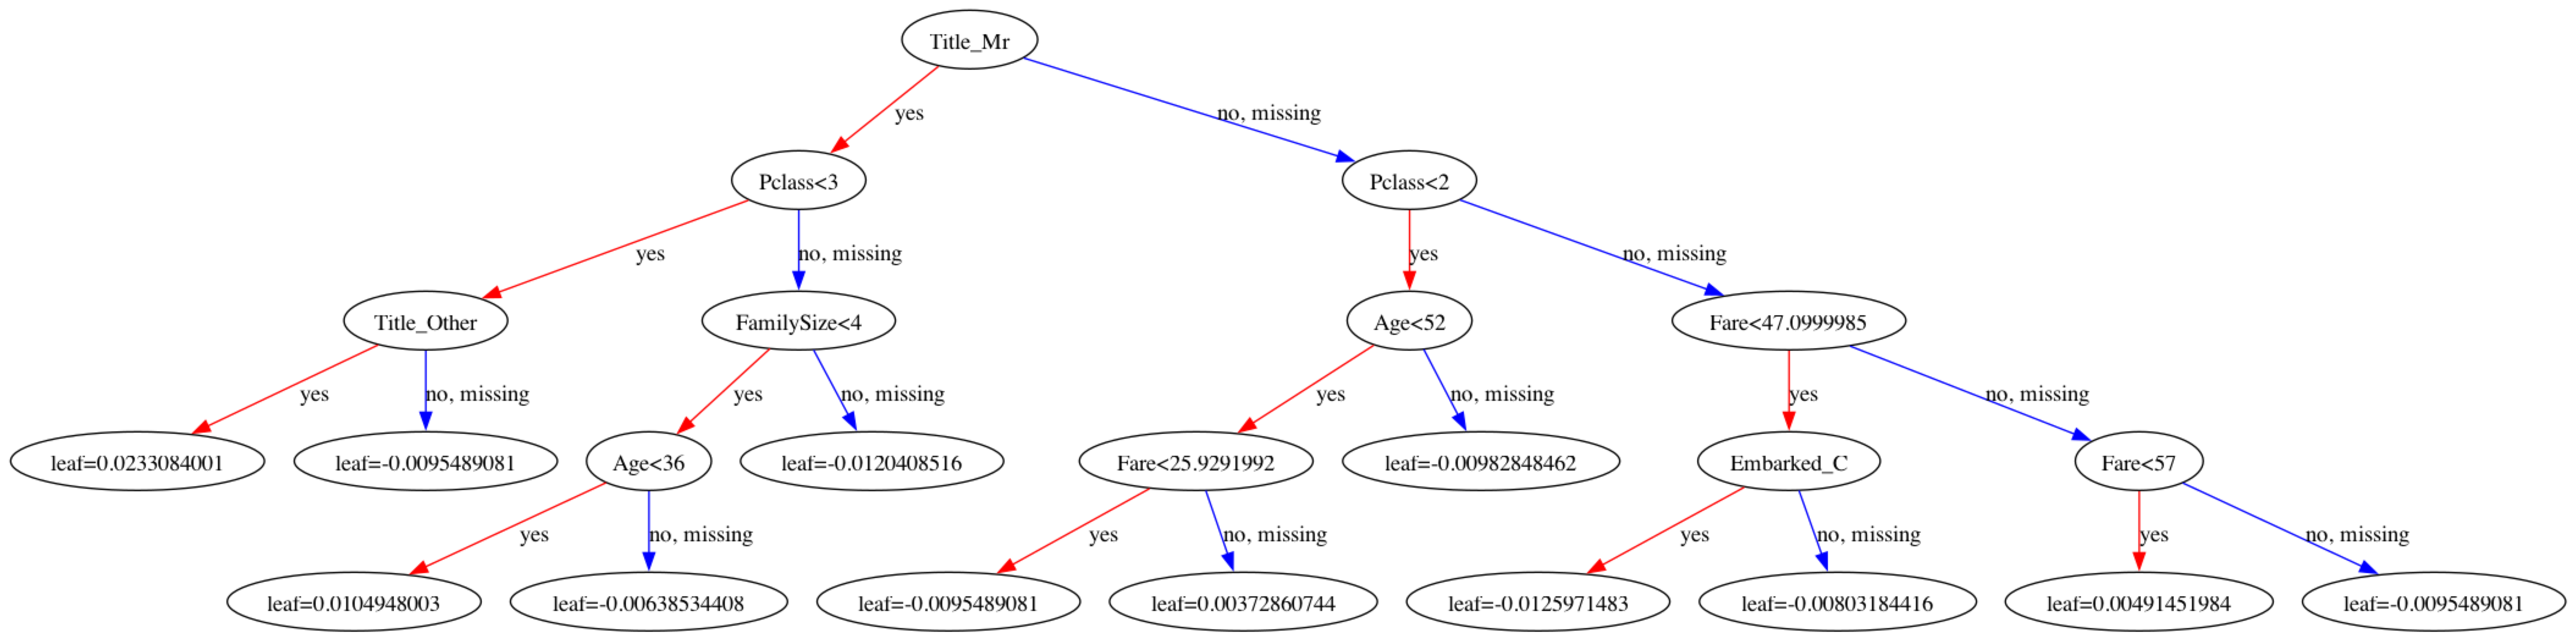

In [6]:
import pandas as pd
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import accuracy_score
from matplotlib.pylab import rcParams
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

# See https://www.kaggle.com/code/ccastleberry/titanic-cabin-features
# def add_cabin_data(data):
#     data['Deck'] = data['Cabin'].str.slice(0,1)
#     data['Room'] = data['Cabin'].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")

# def get_title(name):
#     if "." in name:
#         return name.split(",")[1].split(".")[0].strip()
#     else:
#         return "Unknown"

# def title_map(title):
#     if title in ["Mr"]:
#         return 1
#     elif title in ["Master"]:
#         return 3
#     elif title in ["Ms", "Mlle", "Miss"]:
#         return 4
#     elif title in ["Mme","Mrs"]:
#         return 5
#     else:
#         return 2

def feature_engineer(data):
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)
    data['FamilySize'] = data['SibSp'] + data['Parch']
    eng_title(data)
    eng_age(data)
    # data['SES'] = data['Pclass'] * data['Fare']
    # age_imp = SimpleImputer(strategy="median")
    # data['Age'] = age_imp.fit_transform(data[['Age']])
    # data.dropna(subset=['Age'], inplace=True)
    # data["Cabin"] = data["Cabin"].isna()

# https://www.kaggle.com/code/nicapotato/titanic-feature-engineering
def eng_title(data):
    data['Title']=0
    data['Title']=data.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    data['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Dona','Jonkheer','Col',
                         'Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
    
def eng_age(data):
    data.loc[(data.Age.isnull())&(data.Title=='Mr'),'Age']= data.Age[data.Title=="Mr"].mean()
    data.loc[(data.Age.isnull())&(data.Title=='Mrs'),'Age']= data.Age[data.Title=="Mrs"].mean()
    data.loc[(data.Age.isnull())&(data.Title=='Master'),'Age']= data.Age[data.Title=="Master"].mean()
    data.loc[(data.Age.isnull())&(data.Title=='Miss'),'Age']= data.Age[data.Title=="Miss"].mean()
    data.loc[(data.Age.isnull())&(data.Title=='Other'),'Age']= data.Age[data.Title=="Other"].mean()

#TODO: impute age next (https://www.kaggle.com/code/nicapotato/titanic-feature-engineering), wanna see improvement on title
#TODO: possibly do Embarked and Fare filling https://www.kaggle.com/code/nicapotato/titanic-feature-engineering
    #TODO: possibly df['Embarked'] = df['Embarked'].map( {'Q': 0, 'S': 1, 'C': 2} ).astype(int)


train_data = pd.read_csv('train.csv')
feature_engineer(train_data)

train_data.info()

# add_cabin_data(train_data)


test_data = pd.read_csv('test.csv')
feature_engineer(test_data)

# add_cabin_data(test_data)


features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'FamilySize', 'Fare', 'Embarked']

X_train = train_data[features]
y_train = train_data['Survived']

X_test = test_data[features]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, random_state=1)

# hyperparameter_grid = {
#     'max_depth': [3,6],
#     'learning_rate': [.01],
#     'n_estimators': [50, 100, 500,1000],
#     'subsample': [.3, 0.7, 1],
#     'min_child_weight': range(1,13,2),
#     'colsample_bytree': [i/100.0 for i in range (60, 100, 5)],
#     'reg_alpha': [0, 0.005, 0.01, 0.05, .1]
# }

model = xgb.XGBClassifier(early_stopping_rounds=5, max_depth=4, learning_rate=.01, n_estimators=1000)

# random_cv = RandomizedSearchCV(model, param_distributions=hyperparameter_grid, cv=5, n_iter=50) 
# random_cv.fit(X_train, y_train)

# print(random_cv.best_params_)
# best_model = random_cv.best_estimator_
best_model = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

y_train_pred = best_model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train accuracy: " + str(train_accuracy))

y_valid_pred = best_model.predict(X_valid)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print("Validation accuracy: " + str(valid_accuracy))

rcParams['figure.figsize'] = 80,50
plot_tree(best_model, fontsize=12)

predictions = best_model.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)







In [ ]:
# try all female

# test_data = pd.read_csv('test.csv')
# test_data['Survived'] = test_data.apply(lambda x: 0 if x.Sex=='male'else 1, axis=1)
# test_data[['PassengerId','Survived']].to_csv('female_survive.csv', index=False)